# EDA for Data Incubator project proposal, fall 2020

*Draft 1: How does performance relate to compensation in publicly funded universities?

*Draft 2: How to best model enrollement at public universities?

<hr>

## Purpose of this Jupyter notebook is to work on time series models 

### Here's [my project dashboard](http://barb-data-inc.herokuapp.com/) showing last updated version of dashboard/report.

Refs here:


In [67]:
# --------------------------------
# IMPORT MODULES & LOAD DATA
# --------------------------------
import pandas as pd
import numpy as np
from datetime import datetime as dt

# Import saved csv to dataframe:
path2project = "/Users/bhs/PYTHON-STUFF/DataIncubator/does_good_payoff"
path2file=path2project+"/data/interim/n501-analyzeMe.csv"

df = pd.read_csv(path2file, na_values=np.nan, parse_dates=['year'], low_memory=False,
                   dtype={'unitid':'category', 'inst_name': 'category', 'state_name': 'category',
                         'enrollement_rate': 'float64', 'female_pct': 'float64', 'married_pct': 'float64'})


In [ ]:
# --------------------------------
# HELPER FUNCTIONS => Move to own py file
# --------------------------------

In [68]:
# Prepare list of dicts for STATE drop-down menu
def make_options(df):
    n=df.unitid.nunique()
    state_options=[{'label': 'All '+str(n)+" schools", 'value':''}]
    for state in df.state_name.unique():
        n=df.groupby(['state_name'])['unitid'].nunique().loc[state]
        state_options.append({'label': state+" ("+str(n)+" schools)", 'value': state })
    return state_options

# Standard error of mean distribution
def sem_btwn(x):
    return round(np.std(x)/np.sqrt(x.count()),3)

# Create a summary of early yrs - late yrs:
def tbl_early_late(df):
    tbl = pd.concat([pd.DataFrame(df[0:2].apply(np.mean),columns=['Avg 2001-02']),
            pd.DataFrame(df[-2:].apply(np.mean),columns=['Avg 2016-17'])],axis=1)
    return round(pd.concat([tbl, 
            pd.DataFrame(df[0:2].apply(np.mean) - df[-2:].apply(np.mean), columns=['DIFF'])],axis=1),3)


# Filter data for a balanced dataset w.r.t. measure-of-interest
def get_school_data(df, which_columns=['number_enrolled_total'], earliestYr=0, nYrs=0):
    # Use this to find the most common number of years for which data exists:
    if nYrs==0:
        nYrs = df.groupby(['unitid'])[which_columns[0]].count().value_counts().index[0]

    # Filter years, if desired
    df = df[df.year.dt.year>=earliestYr]

    # Make a temp df with number of years w/ data available for key measure
    tmpDf = df.groupby('unitid')[which_columns].count()

    # Make a list of schools w/ data in all years, only include those:
    unitids = tmpDf[tmpDf[which_columns[0]]==nYrs].index.to_list()
    filt = df.apply(lambda row: row['unitid'] in unitids, axis=1)

    # print(f"These were the input parameters: {which_columns[0]}, {earliestYr}")
    # print(f"Returning a data frame w: {df[filt].unitid.nunique()} schools data in, from {df[filt].year.min().year} thru {df[filt].year.max().year} (that makes {nYrs} yrs of data for {which_columns[0]})")
    
    # Return a dataframe with balanced data for measure of interest
    return df[filt]

def augmented_dicky_fuller_statistics(time_series):
    from statsmodels.tsa.stattools import adfuller
    """
    Run the augmented Dicky-Fuller test on a time series to determine if it's stationary
    Arguments:
        time_series:  series. Time series to be tested. 
    Output: 
        Test statistics for the augmented Dicky Fuller test in the console
    """
    result = adfuller(time_series.values)
#     print('ADF Statistic: %f' % result[0])
#     print('p-value: %f' % result[1])
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print('\t%s: %.3f' % (key, value))
    return result

# https://en.wikipedia.org/wiki/Approximate_entropy
def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))


In [69]:
# --------------------------------
# Prune Features, axis=1: (Drop some columns)
# --------------------------------

# Keep these columns (subset from CSV) as potential features for model:
keepcols = ['admission_rate','enrollement_rate','number_applied','number_admitted','number_enrolled_total',
        'rev_tuition_fees_gross', 'rev_tuition_fees_net','rev_total_current','rev_fed_approps_grants','rev_state_local_approps_grants','rev_other',
       'exp_total_current','exp_instruc_total','exp_acad_supp_total','exp_student_serv_total','exp_res_pub_serv_total',
        'completers_150pct','completion_rate_150pct','female_pct','married_pct',
      'year','unitid','inst_name','state_name']

dropcols = [c for c in df.columns if c not in keepcols]
df.drop(dropcols,axis=1,inplace=True)


In [70]:
# --------------------------------
# Prune Data, axis=0: (Check for availability of key measure in enough years to make a time series)
# --------------------------------

# DATA FOR ENROLLMENT SECTION
df_enroll  = get_school_data(df, ['enrollement_rate'], 2001)
state_options_enrollment = make_options(df_enroll)
df['unitid'] = df['unitid'].astype('object')  #for plotting later
df['inst_name'] = df['inst_name'].astype('object')   #for plotting later

# DATA FOR FINANCE SECTION
dfFin1 = get_school_data(df, ['rev_total_current'])
state_options_finance = make_options(dfFin1)


In [ ]:
# # --------------------------------
# # PREPARE DATA - 
# # --------------------------------

# df['exp_OTHER_STUFF'] = df['exp_total_current'] - \
#     (dfFin1['exp_instruc_total']+dfFin1['exp_res_pub_serv_total']+dfFin1['exp_acad_supp_total']+dfFin1['exp_student_serv_total'])

# df['rev_OTHER_STUFF'] = df['rev_total_current'] - \
#     (dfFin1['rev_tuition_fees_net']+dfFin1['rev_fed_approps_grants']+dfFin1['rev_state_local_approps_grants']+dfFin1['rev_other'])

# which_cols = ['exp_instruc_total', 'exp_res_pub_serv_total', 'exp_acad_supp_total', 'exp_student_serv_total', 'exp_OTHER_STUFF']
# dfExp = pd.melt(df, id_vars =['year','unitid','inst_name','state_name'], value_vars= which_cols)

# which_cols = ['rev_tuition_fees_net', 'rev_fed_approps_grants', 'rev_state_local_approps_grants', 'rev_other', 'rev_OTHER_STUFF']
# dfRev = pd.melt(df, id_vars =['year','unitid','inst_name','state_name'], value_vars= which_cols)



In [ ]:
# If I need to creat any more dataframes, do it here:


In [ ]:
seriez = {'number_applied': {'color': '#F44DDB', 'label': "Number of student applications", 'timeDep': 'Yes', 'marker_color': 'rgba(152, 0, 0, .8)'},
            'number_admitted': {'color': '#CF1214', 'label': "Number of students admitted", 'timeDep': 'Yes', 'marker_color': 'rgba(152, 0, 0, .8)'},
            'number_enrolled_total': {'color': '#0E3DEC', 'label': "Number enrolled", 'timeDep': 'Yes', 'marker_color': 'rgba(152, 0, 0, .8)'},
            'admission_rate': {'color': '#CF1214', 'label': "Admission rate (# applications/# admissions)", 'timeDep': 'Yes', 'marker_color': 'rgba(152, 0, 0, .8)'},
            'enrollement_rate': {'color': '#0E3DEC', 'label': "Enrollment rate (# admissions/# enrolled", 'timeDep': 'Yes', 'marker_color': 'rgba(152, 0, 0, .8)'},
            'rev_tuition_fees_gross': {'color': '#8E44AD', 'label': "Revenue: Tuition&Fees (gross)", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'rev_tuition_fees_net': {'color': '#2E86C1 ', 'label': "Revenue: Tuition&Fees (net)", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'rev_total_current': {'color': '#1E8449', 'label': "Revenue: Total", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'rev_fed_approps_grants': {'color': '#F1948A', 'label': "Revenue: Fed grants & approp", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'rev_state_local_approps_grants': {'color': '#C0392B', 'label': "Revenue: State grants & approp", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'rev_other': {'color': '#00ACC1', 'label': "Revenue: Other", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'exp_total_current': {'color': '#F4D03F', 'label': "Expenses: Total", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'exp_instruc_total': {'color': '#FFA726', 'label': "Expenses: Instruction", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'exp_acad_supp_total': {'color': '#B2EBF2', 'label': "Expenses: Acad Supp", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'exp_student_serv_total': {'color': '##D7CCC8', 'label': "Expenses: Stud Serv", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'exp_res_pub_serv_total': {'color': '#0E3DEC', 'label': "Expenses: Resch & Pub Serv", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'completers_150pct': {'color': '#0E3DEC', 'label': "Completers 150%", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'completion_rate_150pct': {'color': '#0E3DEC', 'label': "Completion Rate 150%", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'female_pct': {'color': '#0E3DEC', 'label': "% Female", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'married_pct': {'color': '#0E3DEC', 'label': "% Marries", 'timeDep': 'Yes', 'marker_color': 'rgba(250, 250, 250, .8)'},
            'state_name': {'color': '#0E3DEC', 'label': "State", 'timeDep': 'No', 'marker_color': 'rgba(250, 250, 250, .8)'},
        }


# EVALUATE SUMMARY STATS OF VARIABLES

After running the next couple of cells, I should be able to evaluate:

## Are the features are heteroscedastic? 
(i.e. do they have similar variances)
If not, hopefully log transform will fix that

## Is a time series of the predictor stationary? (prereq for VAR forecasting model)

See file: ../data/processed/

In [71]:
#  *** SUMMARIZE FEATURES, CREATE TABLE ***
# -----------------------------
# STEP 1 DEFINE A MULTILEVEL INDEX
# https://jakevdp.github.io/PythonDataScienceHandbook/03.05-hierarchical-indexing.html

# Keep these columns (subset from CSV) as potential features for model:
keepcols = ['admission_rate','enrollement_rate','number_applied','number_admitted','number_enrolled_total',
        'rev_tuition_fees_gross', 'rev_tuition_fees_net','rev_total_current','rev_fed_approps_grants','rev_state_local_approps_grants','rev_other',
       'exp_total_current','exp_instruc_total','exp_acad_supp_total','exp_student_serv_total','exp_res_pub_serv_total',
        'completers_150pct','completion_rate_150pct','female_pct','married_pct',
      'year','unitid','inst_name','state_name']

keepcols = keepcols[:-4]
index=[]
for k in keepcols:
    index.append((k, 'Raw'))
    index.append((k, 'Log'))
    index.append((k, 'Log-Diff'))
    index.append((k, 'Diff'))


df = df_enroll
    
# -----------------------------
# STEP 2: CREATE ALL THE SERIES I NEED TO SUMMARIZE:
mean, cnt, varz, adf_stat, adf_pval = [], [], [], [], []
for t in index:
#     print(t)
    if t[1]=='Raw':
        ser=df[t[0]]
        ts=df[[t[0],'year']].groupby('year').agg(np.mean)
    elif t[1]=='Log':
        ser=np.log(df[t[0]])
        df['tmp']=np.log(df[t[0]])
        ts=df[['tmp','year']].groupby('year').agg(np.mean)
    elif t[1]=='Log-Diff':
        ser=np.log(df[t[0]]).diff(1)
        df['tmp']=np.log(df[t[0]]).diff(1)
        ts=df[['tmp','year']].groupby('year').agg(np.mean)
    elif t[1]=='Diff':
        ser=df[t[0]].diff(1)
        df['tmp']=df[t[0]].diff(1)
        ts=df[['tmp','year']].groupby('year').agg(np.mean)
    # mean, cnt, and varz are collapsed across all years, unitids for that feature:
    mean.append(np.mean(ser))
    cnt.append(len(ser.dropna()))
    varz.append(np.var(ser))   
    # adf test looks at stationarity of feature over time, store results:
    res=augmented_dicky_fuller_statistics(ts.dropna())
    adf_stat.append(res[0])
    adf_pval.append(res[1])
    df.drop('tmp',axis=1,inplace=True,errors='ignore')

# -----------------------------
# STEP 3: PUT IT ALL TOGETHER, 
index = pd.MultiIndex.from_tuples(index)

tmp1 = pd.DataFrame(mean, index=index, columns=['mean']).reindex(index)
tmp2 = pd.DataFrame(cnt, index=index, columns=['count']).reindex(index)
tmp3 = pd.DataFrame(varz, index=index, columns=['variance']).reindex(index)
tmp4 = pd.DataFrame(adf_stat, index=index, columns=['ADF_stat']).reindex(index)
tmp5 = pd.DataFrame(adf_pval, index=index, columns=['ADF_pval']).reindex(index)

summary_transformed = pd.concat([tmp2, tmp1, tmp3, tmp4, tmp5], axis=1)

summary_transformed.to_csv(path2project+'Summarize_Feature_distributions.csv')
# print(f"Saved file: {pathDir+'Summarize_Feature_distributions.csv'}")
# pd.options.display.float_format = '{:.3f}'.format
summary_transformed

/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log
/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log
/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in log
/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log


count          mean      variance   ADF_stat  \
admission_rate         Raw        2805  6.184299e-01  3.585280e-02  -1.989617   
                       Log        2805 -5.438407e-01  1.552598e-01  -5.018190   
                       Log-Diff   2804  3.725015e-05  3.166713e-02  -2.805357   
                       Diff       2804  2.955467e-05  7.966343e-03  -7.532387   
enrollement_rate       Raw        2805  3.539685e-01  1.616137e-02  -2.773471   
                       Log        2805 -1.102095e+00  1.306945e-01  -1.893375   
                       Log-Diff   2804  9.165074e-05  3.292637e-02 -37.088050   
                       Diff       2804  4.128398e-05  5.507624e-03   1.407217   
number_applied         Raw        2805  1.677556e+04  1.675739e+08  -0.807105   
                       Log        2805  9.468669e+00  5.273298e-01  -3.559925   
                       Log-Diff   2804 -6.211788e-04  8.942868e-02 -51.438646   
                       Diff       2804 -6.136234e+00  3.201514e+07  -2.263970   
number_admitted        Raw        2805  9.088216e+03  3.338286e+07   1.476539   
                       Log        2805  8.924829e+00  3.837351e-01  -1.509017   
                       Log-Diff   2804 -5.839286e-04  7.553546e-02 -46.162328   
                       Diff       2804 -4.510699e+00  6.620430e+06  -5.059287   
number_enrolled_total  Raw        2805  2.911067e+03  2.927846e+06  -0.732428   
                       Log        2805  7.822733e+00  2.988297e-01  -1.102425   
                       Log-Diff   2804 -4.922779e-04  4.351881e-02 -25.247618   
                       Diff       2804 -1.655849e+00  4.537892e+05  -1.919902   
rev_tuition_fees_gross Raw        2788  2.625407e+08  7.638048e+16   1.192306   
                       Log        2788  1.894071e+01  9.355548e-01  -5.464184   
                       Log-Diff   2786 -1.238139e-03  1.596210e-01  -0.182301   
                       Diff       2786 -2.705587e+05  1.399249e+16  -2.835163   
rev_tuition_fees_net   Raw        2770  2.007388e+08  4.708541e+16   0.699875   
                       Log        2770  1.867279e+01  9.183421e-01  -3.678455   
                       Log-Diff   2751  4.504502e-03  1.444163e-01 -36.477997   
                       Diff       2751  5.284160e+05  7.727409e+15  -2.555188   
rev_total_current      Raw        2788  8.647105e+08  1.555728e+18   2.316746   
                       Log        2786  1.994050e+01  1.122235e+00  -2.005311   
...                                ...           ...           ...        ...   
exp_instruc_total      Log-Diff   2786 -1.406357e-03  1.002014e-01 -39.125686   
                       Diff       2786 -2.744498e+05  1.047620e+16  -2.523660   
exp_acad_supp_total    Raw        2788  6.616155e+07  8.448731e+15   2.002306   
                       Log        2788  1.747216e+01  9.825237e-01  -2.601717   
                       Log-Diff   2786 -1.689974e-03  1.448241e-01   0.454538   
                       Diff       2786 -1.005077e+05  1.378699e+15 -52.460577   
exp_student_serv_total Raw        2788  3.701652e+07  1.131402e+15   2.126344   
                       Log        2788  1.711527e+01  6.243581e-01  -3.069466   
                       Log-Diff   2786 -6.903606e-04  1.011867e-01 -57.145891   
                       Diff       2786 -2.957069e+04  2.185733e+14 -61.533390   
exp_res_pub_serv_total Raw        2770  1.462970e+08  6.097699e+16  -2.381869   
                       Log        2770  1.722030e+01  3.939317e+00  -3.847524   
                       Log-Diff   2766 -1.181969e-03  3.748235e-01 -33.346568   
                       Diff       2766 -1.630385e+05  7.531890e+15  -2.263725   
completers_150pct      Raw        2640  1.674621e+03  1.585328e+06  -2.284136   
                       Log        2640  7.186221e+00  4.586844e-01  -2.529541   
                       Log-Diff   2475  3.503444e-02  8.739970e-03  -2.426534   
                       Diff       2475  5.141616e+01  2.652206e+

In [72]:
summary_transformed.to_csv(path2project+'/data/interim/Summarize_Feature_distributions.csv')

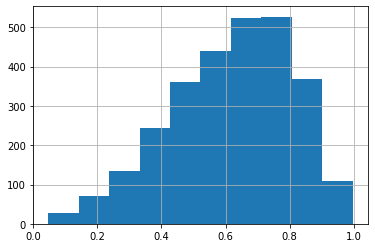

<Figure size 720x432 with 0 Axes>

In [86]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

show_var = 'admission_rate'
trans_type = 'Log'
# df_enroll[show_var].hist()

fig = make_subplots(rows=2, cols=1)
fig.addtrace(go.Histogram(, row=2, col=1)
fig.addtrace(go.Scatter(, row=2, col=1)
fig.update_layout(height=500, showlegend=False)
fig.show()
    
# # def tsplot(y, title, lags=None, figsize=(10, 6)):
#     fig = plt.figure(figsize=figsize)
#     layout = (2, 2)
#     ts_ax = plt.subplot2grid(layout, (0, 0))
#     hist_ax = plt.subplot2grid(layout, (0, 1))
#     acf_ax = plt.subplot2grid(layout, (1, 0))
#     pacf_ax = plt.subplot2grid(layout, (1, 1))

#     y.plot(ax=ts_ax)
#     ts_ax.set_title(title, fontsize=12, fontweight='bold')
#     y.plot(ax=hist_ax, kind='hist', bins=25)
#     hist_ax.set_title('Histogram')
#     sm.tsa.graphics.plot_acf(y, lags=lags, ax=acf_ax)
#     sm.tsa.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
#     sns.despine()
#     plt.tight_layout()
#     plt.show()
#     return ts_ax, acf_ax, pacf_ax


### Decide how each feature should be transformed & make a new dataframe

Ok, I decided. **Transforming the features by Log & Diff is the way to go.**
- I looked at the mean, variance, and stationarity of each of the tranformations for each of the features. 
- The features are homeoskedastic (similar variance = 0) with this tranformation.
- Also, the time series are stationary under this transformation. 
- Perhaps that will lead to better model results.


## Prep data for linearmodels.panel models

APPROACH:
- Run models on Raw and Transformed features
- For each: Train on data from 2001-2016, use 11 features to predict each school's "number_enrolled_total" 
- Evaluate models performance on predicting 2017 "number_enrolled_total"

In [55]:
df_trans = df.copy()
df_log = df.copy()
df_diff = df.copy()

# keepcols = ['admission_rate','enrollement_rate','number_applied','number_admitted','number_enrolled_total',
#         'rev_tuition_fees_gross', 'rev_tuition_fees_net','rev_total_current','rev_fed_approps_grants','rev_state_local_approps_grants','rev_other',
#        'exp_total_current','exp_instruc_total','exp_acad_supp_total','exp_student_serv_total','exp_res_pub_serv_total',
#         'completers_150pct','completion_rate_150pct','female_pct','married_pct']

#Take LOG & then DIFFERENCE the elements
for k in keepcols:
    if k not in ['year','unitid','inst_name','state_name']:
        df_trans[k] = np.log(df[k]).diff(1)  

#Take LOG
for k in keepcols:
    if k not in ['year','unitid','inst_name','state_name']:
        df_log[k] = np.log(df[k]) 
 
#DIFFERENCE the elements
for k in keepcols:
    if k not in ['year','unitid','inst_name','state_name']:
        df_diff[k]=df[k].diff(1)

# Setup Multilevel index for Panel models:
df = df.set_index(['unitid','year'])
df_trans = df_trans.set_index(['unitid','year'])
df_log = df_log.set_index(['unitid','year'])
df_diff = df_diff.set_index(['unitid','year'])



/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/Applications/anaconda/envs/py37t/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


# Predictions, Estimations, Forecasting

In [43]:
# IMPORT ALL THE LIBRARIES NEEDED:

from linearmodels.panel import PooledOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import PanelOLS
from linearmodels.panel import compare
import statsmodels.api as sm

from statsmodels.tsa.stattools import grangercausalitytests


## 1. Basic regression on panel data
PooledOLS is just plain Oridinary Least Squares that understands panel data structures.
It can be useful as a base model:
    

In [ ]:
# TOGGLE BTWN WHICH FEATURES TO USE: 
# -RAW  -LOG_DIFF  -LOG  -DIFF

# DF, TRANS_TYPE = df, 'RAW'

DF, TRANS_TYPE = df_trans, 'LOG_DIFF'

# DF, TRANS_TYPE = df_log,  'LOG'

# DF, TRANS_TYPE = df_diff, 'DIFF'

# What's being predicted:
whichVar = 'number_enrolled_total'
dependent = DF[whichVar]

# Settle on regressors:
modelcols = [c for c in keepcols if c not in [whichVar,'admission_rate','enrollement_rate','year','unitid','inst_name','state_name']]

# Add em to statsmodel:
exog = sm.add_constant(DF[modelcols])

mod = PooledOLS(dependent, exog)
pooled_res = mod.fit()
print(pooled_res)

## 2. Estimating parameters with uncorrelated effects

This model adds an error componend to the standard OLS model.

The Random effects model is almost identical to the pooled OLD model except that it accounts for the structure of the model; subtracts the time average from the within-entity values.

**y = Xb + c + e**
(in Random effects, the "c" are uncorrelated with regressors)


In [ ]:
mod = RandomEffects(dependent, exog)
re_res = mod.fit()
print(re_res)


In [ ]:
# I THINK THESE NUMBERS WOULD BE PRETTY DIFFERENT IF I HADN"T TRANFORMED THE FEATURES

# The quasi-differencing in the random effects estimator depends on a quantity that depends on the #  relative variance of the ideosyncratic shock and the common shock. 
 #This can be accessed using the variance_decomposition:
print(re_res.variance_decomposition)

# Cofficient THETA determines how much demeaning takes place
# when value is 1, the RE model reduces to the pooled model, no variance in the effeicts
# when panels are unbalanced, can vary across entities
print(re_res.theta)

# Handling correlated effects with PanelOLS

When effects are correlated with the regressors, the RE and BE estimators are not consistent. 
Hence, use Fixed Effects model (PanelOLS).


## 3a. FIXED EFFECTS: Entity only

Setting entity_effects=True is equivalent including dummies for each entity. Time-invariant variables cannot be included when using entity effects since, once de-meaned, these will be zero. 

In [ ]:
# FIXED EFFECTS model: ENTITY only

mod = PanelOLS(dependent, exog, entity_effects=True)
fe_ent_res = mod.fit(cov_type='unadjusted')
print(fe_ent_res)

## 3b. FIXED EFFECTS: Entity & Time

In [ ]:
mod = PanelOLS(dependent, exog, entity_effects=True, time_effects=True)
fe_ent_tm_res = mod.fit(cov_type='unadjusted')
print(fe_ent_tm_res)

## COMPARE MODELS

In [ ]:
compare({'Pooled': pooled_res, 'RE': re_res, 'Fixed-Ent': fe_ent_res})

In [ ]:
compare({'RE': re_res, 'Fixed-Ent': fe_ent_res, 'Fixed-Ent-Tm': fe_ent_tm_res})

In [ ]:
compare({'Pooled': pooled_res, 'RE': re_res, 'Fixed-Ent-Tm': fe_ent_tm_res})

In [ ]:
# Heteroskedasticity Robust Covariance

mod = PooledOLS(dependent, exog)
robust = mod.fit(cov_type='robust')


## 4a. Covariance Options: Cluster by ENTITY

In [ ]:

mod = PooledOLS(dependent, exog)
clust_entity = mod.fit(cov_type='clustered', cluster_entity=True)


## 4b. Covariance Options: Cluster by ENTITY & TIME

In [ ]:
mod = PooledOLS(dependent, exog)
clust_entity_time = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)


In [ ]:
from collections import OrderedDict
res = OrderedDict()
res['Robust'] = robust
res['Entity'] = clust_entity
res['Entity-Time'] = clust_entity_time
res['Pooled'] = pooled_res
res['RE'] = re_res
res['FE-ent'] = fe_ent_res
res['FE-ent-tm'] = fe_ent_tm_res

In [ ]:
# %%capture cap --no-stderr

# print(compare(res))
# with open('output_model_results_features_'+TRANS_TYPE+'.txt', 'w') as f:
#     f.write(cap.stdout)

clust_entity_time

In [ ]:
# Notes from the examples page for linearmodels 4.5
# -------------------------------------------
# Clustering by entity addresses correlation across time
# Clustering by time controls for correlation between entities in a time period.

# In my data:
# "Clustering on entity reduced the t-stats across the board. 
# "This suggests there is important correlation in the residuals per entity
#
# "Clustering by both entity and time is pretty similar => 
#  .... this suggests there may not be cross-sectional dependence in the data


## TIME TO TRY FORECASTING!


In [ ]:
# RAW DATA: df 
# LOG-DIFF: df_trans
# LOG: df_log
# DIFF: df_diff 

# whichFeatures = ['number_applied', 'number_admitted', 'rev_tuition_fees_net','completers_150pct',
#                  'rev_fed_approps_grants', 'rev_state_local_approps_grants', 'rev_other',
#                'exp_instruc_total','exp_acad_supp_total','exp_student_serv_total','exp_res_pub_serv_total']

# DF = df_trans


In [85]:
# from dateutil.parser import parse 
# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
%matplotlib inline
import cufflinks as cf
init_notebook_mode(connected=True)

In [14]:
# Goal =>
# Train Data: YEARS 2001-16
# Test Data: YEARS 2017

df = df_enroll
known_data_y = 'number_enrolled_total'
known_data_x = 'number_applied'
DFys = df.groupby(['year','unitid'])[known_data_y].sum().unstack()
DFxs = df.groupby(['year','unitid'])[known_data_x].sum().unstack()


In [42]:
# I want an array with the approx entropy of each school's variable's data but I was having a difficult time w the mechanics...
# TEMP STRATEGY: print values to screen & c&p into spreadsheet

sid = df.unitid.unique()[0]
entrop = np.zeros(df.unitid.nunique())
# keepcols = ['admission_rate','enrollement_rate','number_applied','number_admitted','number_enrolled_total',
#         'rev_tuition_fees_gross', 'rev_tuition_fees_net','rev_total_current','rev_fed_approps_grants','rev_state_local_approps_grants','rev_other',
#        'exp_total_current','exp_instruc_total','exp_acad_supp_total','exp_student_serv_total','exp_res_pub_serv_total',
#         'completers_150pct','completion_rate_150pct','female_pct','married_pct']
    
for sid in df.unitid.unique():
        values = df[df.unitid==sid].groupby('year')['number_applied'].sum()
        c1=ApEn(values[:-1], m=2, r=0.2*np.std(values[:-1]))
        values = df[df.unitid==sid].groupby('year')['number_admitted'].sum()
        c2=ApEn(values[:-1], m=2, r=0.2*np.std(values[:-1]))
        values = df[df.unitid==sid].groupby('year')['number_enrolled_total'].sum()
        c3=ApEn(values[:-1], m=2, r=0.2*np.std(values[:-1]))
        values = df[df.unitid==sid].groupby('year')['admission_rate'].sum()
        c4=ApEn(values[:-1], m=2, r=0.2*np.std(values[:-1]))
        values = df[df.unitid==sid].groupby('year')['enrollement_rate'].sum()
        c5=ApEn(values[:-1], m=2, r=0.2*np.std(values[:-1]))
        values = df[df.unitid==sid].groupby('year')['rev_total_current'].sum()
        c6=ApEn(values[:-1], m=2, r=0.2*np.std(values[:-1]))
        values = df[df.unitid==sid].groupby('year')['exp_total_current'].sum()
        c7=ApEn(values[:-1], m=2, r=0.2*np.std(values[:-1]))
        values = df[df.unitid==sid].groupby('year')['exp_instruc_total'].sum()
        c8=ApEn(values[:-1], m=2, r=0.2*np.std(values[:-1]))
        values = df[df.unitid==sid].groupby('year')['rev_tuition_fees_gross'].sum()
        c9=ApEn(values[:-1], m=2, r=0.2*np.std(values[:-1]))
        c10=len(values[:-1])
        print(f"{sid},{c1},{c2},{c3},{c4},{c5},{c6},{c7},{c8},{c9},{c10}")


104151,0.023426752587707433,0.20826600073702695,0.20166459901740819,0.06899287148695166,0.023426752587707433,0.043360015207310365,0.1772543070983943,0.23654780860171165,0.012816428139820868,16
104179,0.051708560452393026,0.11584637666236697,0.22869560622461949,0.06899287148695166,0.09666757183224872,0.023426752587707433,0.023426752587707877,0.01682535086808956,0.018047915228716516,16
105330,0.1890871959069078,0.11584637666236697,0.1890871959069078,0.11584637666236697,0.22355645067627927,0.18908719590690826,0.14412818452705212,0.15807550226827516,0.03339338389750912,16
110422,0.10924497494274865,0.23808300297596108,0.023426752587707433,0.30318722612663374,0.23409592472425023,0.06899287148695166,0.23654780860171165,0.023426752587707433,0.012816428139820424,16
110510,0.16330698935717125,0.18248579418728994,0.023426752587707433,0.2606816226391384,0.38933600796872847,0.051708560452393026,0.16990839107678957,0.023426752587707433,0.09742202962173252,16
110529,0.18248579418728994,0.06899287148

150136,0.19643311192851254,0.1576883298860361,0.06899287148695166,0.26482961646639636,0.06899287148695166,0.2082660007370274,0.012816428139820424,0.023426752587707877,0.0848346830237352,16
151102,0.023426752587707433,0.11584637666236697,0.023426752587707877,0.12558947599766723,0.023426752587707433,0.2365478086017112,0.28150681998156735,0.023426752587707877,0.038624870986404325,16
151111,0.15768832988603654,0.065268705811377,0.2979557390377381,0.2082660007370265,0.03339338389750912,0.11584637666236697,0.11584637666236697,0.08346476839301253,0.023426752587707877,16
151306,0.11584637666236697,0.11584637666236697,0.21038042966973514,0.13104449506106386,0.11584637666236697,0.012816428139820424,0.20951680139450035,0.023426752587707433,0.14412818452705212,16
151324,0.13804174700555993,0.31548815135554653,0.023426752587707877,0.11584637666236697,0.20291539967488204,0.07960319593483867,0.154636562467672,0.11584637666236697,0.18248579418728994,16
151351,0.21948343270430115,0.3415448357868711,0.0

196121,0.21736900377159296,0.22195596556420583,0.15072958624667043,0.11584637666236697,0.3289674326763712,0.2082660007370274,0.14412818452705256,0.023426752587707433,0.1929941721279098,16
196130,0.09006617011263085,0.2107676020519742,0.16330698935717125,0.09666757183224872,0.18908719590690826,0.21731036767847067,0.15670558763755338,0.18248579418729038,0.14412818452705256,16
196149,0.11584637666236697,0.06899287148695166,0.03862487098640477,0.11584637666236697,0.11584637666236697,0.18248579418729038,0.11584637666236786,0.051708560452393026,0.15768832988603654,16
196158,0.09666757183224872,0.06899287148695166,0.09666757183224783,0.06899287148695166,0.15072958624667043,0.023426752587707877,0.18908719590690826,0.20826600073702695,0.1052642885113273,16
196167,0.06899287148695166,0.4436092095269155,0.23834035589000457,0.2940842230920677,0.023426752587707433,0.11584637666236697,0.023426752587707877,0.18248579418729038,0.065268705811377,16
196185,0.11584637666236697,0.023426752587707433,0.1158

228529,0.28448487718951143,0.2985665840131897,0.23478230211615148,0.1890871959069078,0.023426752587707877,0.023426752587707877,0.051708560452393026,0.0023534539620295725,0.07960319593483867,16
228723,0.15673719805454533,0.18722093840819465,0.16382195355529605,0.023426752587707433,0.11584637666236697,0.10475800215583853,0.25228767363122717,0.1890871959069078,0.20826600073702695,16
228769,0.023426752587707433,0.3044380267841076,0.20826600073702695,0.06899287148695166,0.06899287148695166,0.23654780860171165,0.20826600073702695,0.11584637666236697,0.07437170884594302,16
228778,0.023426752587707433,0.11584637666236697,0.023426752587707433,0.21736900377159296,0.023426752587707877,0.023426752587707433,0.18248579418728994,0.05629552224500678,0.06526870581137745,16
228875,0.2557266134318308,0.06899287148695166,0.11584637666236697,0.1890871959069078,0.09666757183224872,0.11584637666236697,0.023426752587707433,0.11584637666236697,0.2082660007370265,16
229027,0.07088736528251127,0.2082660007370269

In [65]:

from statsmodels.tsa.stattools import grangercausalitytests

# df = df_log.reset_index()
df = df

# whichVars = ['number_enrolled_total', 'number_applied']
whichVars = ['number_enrolled_total', 'number_admitted']
# whichVars = ['number_enrolled_total', 'rev_total_current']

# for sid in df.unitid.unique():
sid=df.unitid.unique()[0]
tmpDf = df[df.unitid==sid].groupby('year')[whichVars].sum()

grangercausalitytests(tmpDf[whichVars], maxlag=2)




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5382  , p=0.0350  , df_denom=13, df_num=1
ssr based chi2 test:   chi2=6.8162  , p=0.0090  , df=1
likelihood ratio test: chi2=5.6781  , p=0.0172  , df=1
parameter F test:         F=5.5382  , p=0.0350  , df_denom=13, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9311  , p=0.1954  , df_denom=10, df_num=2
ssr based chi2 test:   chi2=5.7934  , p=0.0552  , df=2
likelihood ratio test: chi2=4.8988  , p=0.0863  , df=2
parameter F test:         F=1.9311  , p=0.1954  , df_denom=10, df_num=2


{1: ({'ssr_ftest': (5.538157251285203, 0.03500814327039771, 13.0, 1),
   'ssr_chi2test': (6.816193540043327, 0.0090334907862968, 1),
   'lrtest': (5.678108873628545, 0.017177873320126574, 1),
   'params_ftest': (5.538157251285488, 0.03500814327039373, 13.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.9311219268984918, 0.19535850730521187, 10.0, 2),
   'ssr_chi2test': (5.793365780695476, 0.0552060411619468, 2),
   'lrtest': (4.898756728164074, 0.08634724636895152, 2),
   'params_ftest': (1.9311219268984714, 0.19535850730521473, 10.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [59]:
# df_trans.reset_index().head()

## Granger Causality tests

In [ ]:
# From: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

from statsmodels.tsa.stattools import grangercausalitytests
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
df['month'] = df.date.dt.month
grangercausalitytests(df[['value', 'month']], maxlag=2)


## Try some AR based models...
SUNDAY - 8/9/20


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

ser = df.groupby(['unitid','year'])['enrollement_rate'].aggregate(['mean']).iloc[0:16]['mean'].droplevel('unitid')
tst = df.groupby(['unitid','year'])['enrollement_rate'].aggregate(['mean']).iloc[17]['mean']

model = ARIMA(ser, order=(0, 0, 2))  
results_AR = model.fit(disp=-1)  
plt.plot(ser)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ser)**2))


## Time to fit the VAR model!
Left it here on Sunday night, 8/2/20

In [ ]:
# Remember, this is the general flow...

# Convert the dataframe to a numpy array
master_array = np.array(master_df[['Electricity_Price_log_diff','Nat_Gas_Price_MCF_log_diff']])

# Generate a training and test set for building the model (90/10 split)
training_set = master_array[1:int(0.90*master_array.shape[0])]  #Why sample in order???
test_set = master_array[int(0.90*master_array.shape[0]):]

# Fit to a VAR model
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(endog=training_set)
model_fit = model.fit()

# Print a summary of the model results
model_fit.summary()


## 8-5-20: Trying out the analyses for demo in app.py  (kernel py37t)
Refs:
https://bashtage.github.io/linearmodels/doc/panel/examples/examples.html
<hr>

In [ ]:
## Decompose our time series into its components:

from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

# Multiplicative Decomposition
result_mul = seasonal_decompose(dfTs['enrollement_rate'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(dfTs['enrollement_rate'], model='additive', extrapolate_trend='freq')

# Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
## NOTE: Don't need to Normalize input & target feature(s) this time b/c looking at rates:

# Actually, this first forecast model is done on the rates... so already between 0 and 1. Yay!


In [ ]:
## Step 2- Train/Test split